In [1]:
#importing variables
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()



#Obtain list of S&100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    tickers.append(ticker)
    
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

yf.pdr_override()

for i in tickers:
    try:
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(2000,1,1), end = dt.datetime(2023,1,1))
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
    except:
        no_data.append(i)

    clear_output(wait = True)

all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 

In [2]:
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

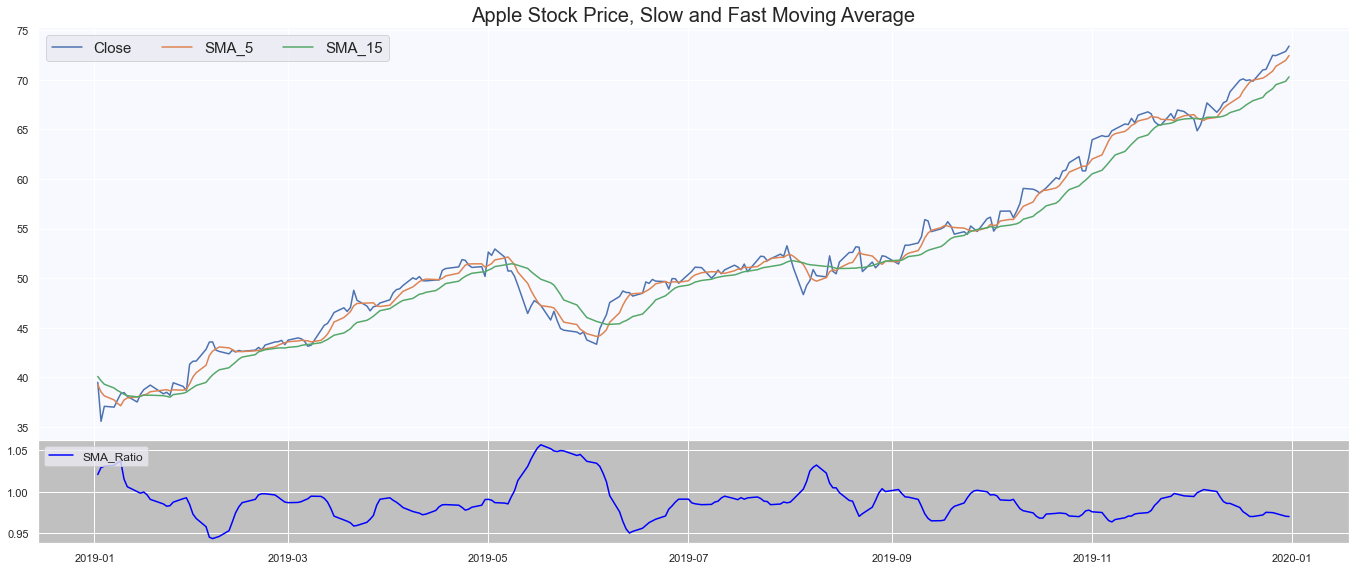

In [3]:
#Plotting
start = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
end = dt.datetime.strptime('2019-12-31', '%Y-%m-%d')
sns.set()

fig = plt.figure(facecolor = 'white', figsize = (20,10))

ax0 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax0.plot(all_data[all_data.symbol=='AAPL'].loc[start:end,['Close','SMA_5','SMA_15']])
ax0.set_facecolor('ghostwhite')
ax0.legend(['Close','SMA_5','SMA_15'],ncol=3, loc = 'upper left', fontsize = 15)
plt.title("Apple Stock Price, Slow and Fast Moving Average", fontsize = 20)

ax1 = plt.subplot2grid((6,4), (5,0), rowspan=1, colspan=4, sharex = ax0)
ax1.plot(all_data[all_data.symbol=='AAPL'].loc[start:end,['SMA_ratio']], color = 'blue')
ax1.legend(['SMA_Ratio'],ncol=3, loc = 'upper left', fontsize = 12)
ax1.set_facecolor('silver')
plt.subplots_adjust(left=.09, bottom=.09, right=1, top=.95, wspace=.20, hspace=0)
plt.show()

In [4]:
all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

In [5]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [6]:
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

In [7]:
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

In [8]:
all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']

In [9]:
all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

In [10]:
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

In [11]:
all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

In [12]:
all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 

In [13]:
all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [14]:
Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])

C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3639039716.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X = transposed.dropna(1).transpose()
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Date    2000-02-14  2000-02-15  2000-02-16  2000-02-17  2000-02-18  \
symbol                                                               
AAPL      0.064942    0.027523   -0.040967    0.006572   -0.031556   
ABT       0.031250    0.001783   -0.012456   -0.012613   -0.047445   
ADBE     -0.008984   -0.008368    0.104782    0.034373   -0.032615   
AIG      -0.011866    0.029353   -0.025275   -0.014628   -0.034413   
AMD      -0.049451    0.005780    0.005747   -0.017143    0.000000   
...            ...         ...         ...         ...         ...   
VZ       -0.012277   -0.019209    0.014977   -0.023837   -0.034884   
WBA       0.006329   -0.044025   -0.035088   -0.004545   -0.043379   
WFC      -0.001650   -0.003306   -0.044776   -0.029514   -0.041145   
WMT       0.050167   -0.014862   -0.090517   -0.082938   -0.012920   
XOM       0.034687    0.037612    0.008668   -0.026563   -0.036918   

Date    2000-02-22  2000-02-23  2000-02-24  2000-02-25  2000-02-28  ...  \
symbol        

C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\sit

,Difference in SS
1,NaN
2,-12.213825
3,-8.989524
4,-4.517139
5,-5.426120
6,-3.096177
7,-2.938107
8,-5.578513
9,-0.294106
10,-1.368080


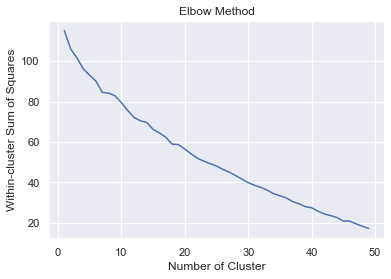

In [15]:
#Extract the returns
returns = all_data[['symbol','return']].copy()
returns['Date'] = returns.index.copy()

#print(returns)

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'Date', columns = 'symbol', values = 'return')

#print(transposed)

#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna(1).transpose()

print(X)

#Extract sum of squares for K-means clusters from 1 to 50 clusters
sum_of_sq = np.zeros([50, 1])
for k in range(1, 51):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_ 
    
plt.plot(range(1, 50), sum_of_sq[1:50])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,51)).diff()

In [16]:
gmm = GaussianMixture(n_components = 24)
gmm.fit(X)#transposed.transpose().dropna().transpose())

#Predict for each company
clusters = gmm.predict(X)#transposed.transpose().dropna().transpose())

clusters_df = pd.DataFrame(data={'Cluster':clusters, 'Companies':X.index.values})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
clusters_df.to_csv("clusters.csv")
clusters_df = pd.read_csv("clusters.csv", index_col = 0)

C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rockm\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [17]:
all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc[:'2018-12-31',]
test_data = all_data.loc['2019-01-01':]

C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\994285298.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = all_data.loc['2019-01-01':]


C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\4109535166.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  X = X_train['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],


Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

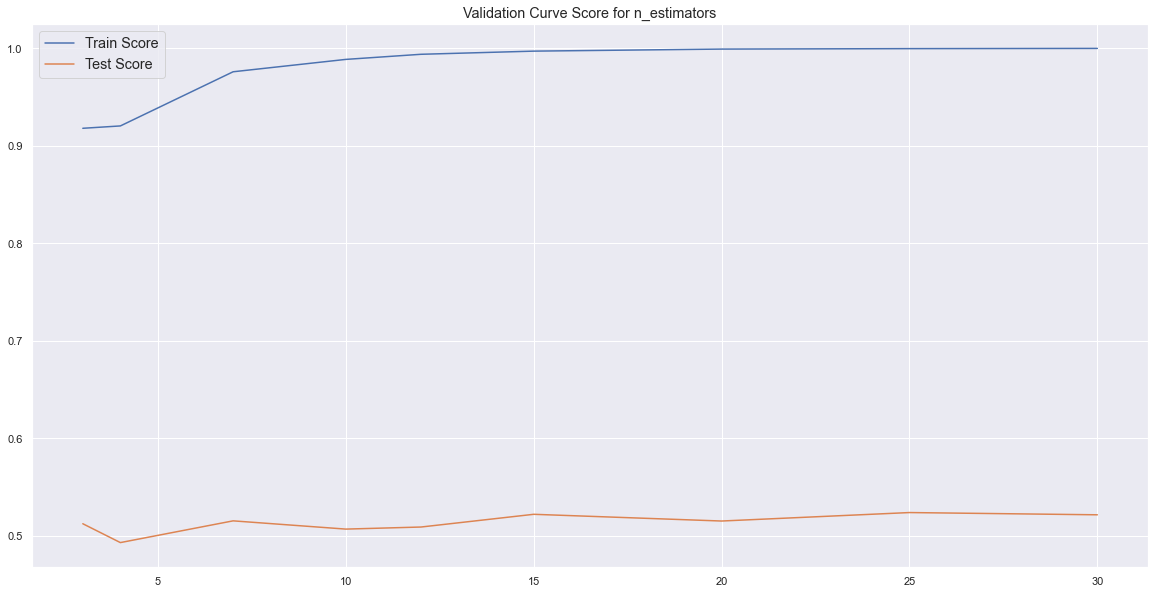

In [18]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'], 
                                param_name = 'n_estimators', 
                                param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')

In [19]:
#Run the loop for every unique cluster - 17 loops
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_data = all_data[all_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    co_train = co_data[:'2018-12-31']
    co_train = co_train.dropna().copy()
    
    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,['Target_Direction']]

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)

    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}\Pickle_Files\Cluster_{cluster_selected}'    
    pickle.dump(rf_cv, open(file_loc,'wb'))

The current cluster running is : 0
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 1
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 2
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 3
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 4
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 5
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 6
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 7
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 8
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 9
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 10
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 11
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 12
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 13
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 14
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 15
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 16
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 17
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 18
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 19
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 20
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 21
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 22
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is : 23
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\rockm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [20]:
#Use 2nd January Data
today = test_data.loc['2019-01-02']

def predictor(day_data):

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                      'company':[],
                                      'prediction':[]})

    #Predict each stock using the 2nd January Data
    for cluster_selected in clusters_df.Cluster.unique():
        rf_cv =  pickle.load(open(os.getcwd() + f'\\Pickle_Files\\Cluster_{cluster_selected}', 'rb'))
        best_rf = rf_cv.best_estimator_
        cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables]

            pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                       'company':cluster_data['symbol'],
                                                                       'prediction':best_rf.predict_proba(X_test)[:,1]}), ignore_index = True)
    
    top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(10)

    for selected_company in top_10_pred['company']:
        actual = all_data[all_data.symbol == selected_company].loc['2019-01-02','Target_Direction']
        pct_change = all_data[all_data.symbol == selected_company].loc['2019-01-02','Target']
        top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
        top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change
    
    return top_10_pred

top_10_pred = predictor(today)

C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be 

In [21]:
def backtest(balance):
    holdings = []
    
    for delta in top_10_pred['pct_change']:
        holdings.append(0.1*balance*(1+delta/100))
        
    return sum(holdings)

In [22]:
balance = 100000

test_data = all_data.loc['2019-01-01':]
date_generated = pd.date_range(start = '2019-01-02', end = '2022-01-02')

num_days = 0
for i in date_generated:
    print(num_days)
    if num_days%7 == 0:
        print(i)
        print(predictor(test_data.loc[i]))
    if datetime.datetime.strptime(i, "%m-%d") != '12-25':
        num_days += 1

'''
curr_data = all_data.loc['2019-01-01':'2019-01-15']
num_days = 0
print(curr_data.index.values[0])
for day in curr_data.index.values:
    print(num_days, day)
    #if num_days%7 == 0:
    #    print("buy")
    #    predictor(curr_data.loc[day])
    #    balance = backtest(balance)
    num_days += 1

print(balance)'''


C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3476682854.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_data = all_data.loc['2019-01-01':]
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0
2019-01-02 00:00:00


C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
C:\Users\rockm\AppData\Local\Temp\ipykernel_12228\3235257290.py:19: FutureWarning: The frame.append method is deprecated and will be 

                   Date company  prediction  actual  pct_change
55  2019-01-02 00:00:00    ADBE    0.693180     1.0    7.547083
64  2019-01-02 00:00:00     FDX    0.621932     1.0    5.686391
42  2019-01-02 00:00:00     MDT    0.613554     0.0   -3.172799
41  2019-01-02 00:00:00     MCD    0.589163     1.0    3.944143
46  2019-01-02 00:00:00     PEP    0.589163     0.0   -0.688642
1   2019-01-02 00:00:00    GILD    0.587480     1.0    2.820942
3   2019-01-02 00:00:00     HON    0.585165     1.0    3.981828
37  2019-01-02 00:00:00     JNJ    0.580692     1.0    1.256439
69  2019-01-02 00:00:00     COP    0.569175     1.0    4.485361
51  2019-01-02 00:00:00     UNH    0.565527     1.0    1.720882


NameError: name 'datetime' is not defined